# Effectuez une prédiction de revenus

### Mission 2

- Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour 5 à 10 pays que vous aurez choisis pour montrer la diversité des cas.
- Représentez la courbe de Lorenz de chacun des pays choisis.
- Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.
- Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?

 

## Sommaire
- [importation des librairies](#librairies)
- [importation et lecture des données](#donnee_revenus)
- [clustering pour le choix des pays de l'étude](#KMeans)
    - [etude des groupes obtenus (tests...)](#etude_groupes)
- [ACP](#acp)
- [retrait des 2 outliers pour un nouveau KMeans](#reKMeans)
    -[étude des nouveaux groupes (tests...)](#reetude_gpes)
- [ACP sur le nouveau clustering](#reacp)
- [calcul de la qualité de représentation des différents pays](#pays_qual)
- [pays retenus pour l'analyse](#pays_retenus)
- [diversité des pays en termes de distribution de revenus à l'aide d'un graphique](#diversite_pays)
    - [visualisation de la distribution des revenus pour les pays choisis](#graph_diversite_pays)
- [courbes de Lorentz pour les pays choisis](#lorentz_pays)
- [pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans](#gini_pays)
    - [importation et lecture des données d'indices de Gini](#import_gini)
- [compte tenu du nombre d'indices de gini manquants pour les pays choisis, nouveau choix de pays](#nvx_pays)
    - [les nouveaux pays choisis sont](#nvx_pays_liste)
    - [visualisation de la diversité des nouveaux pays choisis en termes de distribution de revenus](#re_gph_diver_pays)
    - [courbes de Lorentz pour les nouveaux pays choisis](#re_lorentz_pays)
- [pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans](#re_gini_pays) 
    - [visualisation pour chacun de ces pays, de l'évolution de l'indice de Gini au fil des ans](#evol_gini_pays)
- [classez les pays par indice de Gini](#class_gini_pays)
    - [les 5 pays avec l'indice de Gini le plus élevé](#gini_fort)
    - [Les 5 pays avec l'indice de Gini le plus faible](#gini_faible)
    - [position de la France](#pos_gini_france)

Elements de travail :
- années utilisées : 2004, 2006, 2007, 2009, 2010, 2011
- nombre de pays : 166
- nombre de pays choisis : 6    

Démarche :

- KMeans et acp pour le choix de 5 pays

### Importation des librairies <a class="anchor" id="librairies"></a>

In [1]:
# Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


# librairies pour les tests
from scipy.stats import ks_2samp
import scipy.stats as st
from scipy.stats import levene
from scipy.stats import bartlett
from scipy.stats import ttest_ind

#  librairies pour le dendrogramme, Kmeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage,  fcluster, centroid
from scipy.spatial.distance import pdist
from sklearn import decomposition
from yellowbrick.cluster import KElbowVisualizer
from sklearn import cluster

# librairies pour l'ACP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import LineCollection

In [2]:
ENCODAGE = 'UTF-8'

In [3]:
sns.set(style="darkgrid")

In [4]:
# Test de Kolmogorov-Smirnov pour test d'adéquation à une loi normale
def ks_2samp_test(col, df):
    alpha = 0.05
    stat, p_value = ks_2samp(df[col],list(np.random.normal(np.mean(df[col]), np.std(df[col]), 1000)))
    print(f'p_value :{p_value}')
    
    if p_value < alpha :
        return(f'HO rejetée, la variable {col} ne suit pas une loi normale')
    else :
        return (f'HO ne peut pas être rejetée, la variable {col} suit une loi NORMALE')

In [5]:
def bartlett_test(gpe1, gpe2):
    alpha = 0.05
    stat, p = bartlett(gpe1, gpe2)
    print(f'p_value :{p}')
    
    if p < alpha :
        return(f'HO rejetée, les variances des 2 groupes sont inégales')
    else :
        return (f'HO ne peut pas être rejetée, les variances des 2 groupes sont égales')

In [6]:
def levene_test(gpe1, gpe2):
    alpha = 0.05
    stat, p = levene(gpe1, gpe2)
    print(f'p_value :{p}')
    
    if p < alpha :
        return(f'HO rejetée, les variances des 2 groupes sont inégales')
    else :
        return (f'HO ne peut pas être rejetée, les variances des 2 groupes sont égales')

In [7]:
def student_test(gpe1, gpe2):
    alpha = 0.05
    stat, p_value = st.ttest_ind(gpe1.dropna(), gpe2.dropna())
    print(f'p_value :{p_value}')
    
    if p_value < alpha :
        return(f'HO rejetée, les moyennes des 2 groupes sont inégales')
    else :
        return (f'HO ne peut pas être rejetée, les moyennes des 2 groupes sont égales')

In [8]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,7))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="#FC4E07")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="#f6021c", alpha=0.8)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='#3751f5')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
#             plt.show(block=False)      



In [9]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None, centroid=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
             
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,7))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                    
            # affichage des centroides   
            if centroid is not None:
                X_projected_c = pca.transform(centroid)
                plt.scatter(X_projected_c[:, d1], X_projected_c[:, d2], alpha=alpha, c='red', marker = 'd', s = 100)
                
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
#             plt.show(block=False)

In [10]:
# graphique des éboulis des valeurs propres
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.figure(figsize=(7,7))
    plt.bar(np.arange(len(scree))+1, scree, color="#ff3f33")
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="#0c8ef4",marker='o')
    plt.xlabel("rang de l'axe d'inertie", size=12)
    plt.ylabel("pourcentage d'inertie", size=12)
    plt.title("Eboulis des valeurs propres", size=14)
#     plt.show(block=False)

In [11]:
'''Affichage d'une courbe de Lorentz par graphique'''

def courbeLorentz(array, xlabel, ylabel, labelCourbeLorentz, titre):    
    dep = array.values
    lorenz = np.cumsum(np.sort(dep)) / dep.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0
    
    fig, ax = plt.subplots(figsize=[6,6])
# Courbe de Lorentz
# ,drawstyle='steps-post'
    ax = plt.plot(np.linspace(0,1,len(lorenz)),lorenz, label=labelCourbeLorentz)
# Ligne d'égalité   
    ax = plt.plot([0,1], [0,1],  linestyle='dashed', color= 'r', label='droite d\'équirépartition')
    plt.title(titre, size=16)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    return plt.show()

In [12]:
'''Affichage de plusieurs courbes de Lorentz sur un même graphique'''

def multi_courbeLorentz(df, pays_choisis, xlabel, ylabel, titre):
    fig, ax = plt.subplots(figsize=[10,10])
    ax = plt.plot([0,1], [0,1],  linestyle='dashed', color= 'r', label='droite d\'équirépartition')
    for pays in pays_choisis :
        array = df.loc[df['country'] == pays, 'income']
        dep = array.values
        lorenz = np.cumsum(np.sort(dep)) / dep.sum()
        lorenz = np.append([0],lorenz)
        labelCourbeLorentz = f'courbe de Lorentz pour {pays}'
        ax = plt.plot(np.linspace(0,1,len(lorenz)),lorenz, label=labelCourbeLorentz)
    plt.title(titre, size=16)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
#     return plt.show()
    return plt.savefig('courbe_lorentz.jpg')
    

In [13]:
def indiceGini(array):    
    dep = array.values
    lorenz = np.cumsum(np.sort(dep)) / dep.sum()
    lorenz = np.append([0],lorenz)
    
    aire_ss_courbe = lorenz[:-1].sum()/len(lorenz) # aire sous la courbe de Lorenz. La dernière valeur ne participe pas à l'aire, d'où "[:-1]"
    S = 0.5 - aire_ss_courbe # aire entre la 1e bissectrice et la courbe de Lorenz
    gini = 2*S
    return gini

### Importation et lecture des données  <a class="anchor" id="donnee_revenus"></a>

In [14]:
df_revenus_pop = pd.read_csv('revenus_pays_code_pop.csv', encoding= ENCODAGE).copy()

In [15]:
df_distrib_revenus = pd.read_csv('revenus_pays.csv', encoding= ENCODAGE).copy()

### Clustering pour le choix des pays de l'étude <a class="anchor" id="KMeans"></a>

#### KMeans avec les pays et leur revenu médian 

In [16]:
df_revenu_median_gpeK = df_revenus_pop.loc[(df_revenus_pop['quantile'] == 50)].drop(['country_code','year', 'quantile',
                                                                                 'nb_quantiles'], axis=1)

In [17]:
df_revenu_median_gpeK.head(2)

,nb_habitants_2008,income,gdpppp,country
49,2947314.0,2493.8370,7297.0,Albania
149,40080159.0,4132.6655,13220.0,Argentina


In [18]:
df_revenu_median_gpeK.shape

(116, 4)

In [19]:
df_revenu_median_gpeK.columns

Index(['nb_habitants_2008', 'income', 'gdpppp', 'country'], dtype='object')

In [20]:
df_revenu_median_gpeK.set_index('country',drop=True, inplace=True)
df_revenu_median_gpeK.head(2)

,nb_habitants_2008,income,gdpppp
country,,,
Albania,2947314.0,2493.8370,7297.0
Argentina,40080159.0,4132.6655,13220.0


Centrage et reduction des valeurs

In [21]:
# préparation des données pour le clustering
XmediaK = df_revenu_median_gpeK.values
names = df_revenu_median_gpeK.index

In [22]:
#  Standardisation des données
scaler = StandardScaler()
X_scaledMediaK = scaler.fit_transform(XmediaK)

In [23]:
# Vérification de la standardisation
X_scaledMediaK.mean(axis=0)

array([ 2.49441272e-17,  2.39272204e-17, -1.26814268e-17])

In [24]:
# Vérification de la standardisation
X_scaledMediaK.std(axis=0)

array([1., 1., 1.])

In [25]:
nb_cluster = 5

In [26]:
# clustering
res = cluster.KMeans(n_clusters=nb_cluster,random_state = 42)
res.fit(X_scaledMediaK)

KMeans(n_clusters=5, random_state=42)

In [27]:
# Recherche du nombre de clusters optimal
# Décroissance de l'inertie interclasse (k:clusters)
# visualizer = KElbowVisualizer(res, k=(1,12), timings=False)
# visualizer.fit(X_scaledMediaK)
# visualizer.show()  
# plt.savefig("elbow gpeKmeans.jpg")

In [28]:
# Ajout des groupes au dataframe
df_revenu_median_gpeK_clt = df_revenu_median_gpeK.copy()
df_revenu_median_gpeK_clt['cluster'] = res.labels_ 

In [29]:
df_revenu_median_gpeK_clt.head()

,nb_habitants_2008,income,gdpppp,cluster
country,,,,
Albania,2947314.0,2493.8370,7297.0,4
Argentina,40080159.0,4132.6655,13220.0,0
Armenia,2907615.0,1428.1554,5611.0,4
Austria,8321496.0,14569.9170,36193.0,3
Azerbaijan,8763400.0,1939.9401,8101.0,4


In [30]:
df_revenu_median_gpeK_cltSI = df_revenu_median_gpeK_clt.reset_index(drop=True)
df_revenu_median_gpeK_cltSI.head(2)

,nb_habitants_2008,income,gdpppp,cluster
0,2947314.0,2493.8370,7297.0,4
1,40080159.0,4132.6655,13220.0,0


In [31]:
gb = df_revenu_median_gpeK_clt.groupby('cluster')

#### Etude des groupes obtenus <a class="anchor" id="etude_groupes"></a>

In [32]:
gb.size()

cluster
0    25
1     2
2     1
3    22
4    66
dtype: int64

In [33]:
gb.mean()

,nb_habitants_2008,income,gdpppp
cluster,,,
0,2.047254e+07,5304.292284,1.527264e+04
1,1.262662e+09,1157.699500,4.254000e+03
2,8.453560e+05,1443.745700,4.300332e+06
3,4.178360e+07,15643.022455,3.504745e+04
4,3.404030e+07,1312.897841,4.089382e+03


#### Remarques :
- Gpe 0 : moyen en tout (Grèce, Estonie, Iran...)
- Gpe 1 : nb d'habitants le plus fort  mais income le plus faible (Inde et Chine)
- Gpe 2 : nb_habitants_2008 le plus faible (Fidji)
- Gpe 3 : income le plus fort (Europe...)
- Gpe 4 : gdpppp le plus faible (Afrique, Vietnam...)

In [34]:
gp = df_revenu_median_gpeK_clt[df_revenu_median_gpeK_clt['cluster'] == 0].head(2)

In [35]:
df_revenu_median_gpeK_clt.reset_index(inplace=True)

In [36]:
df_revenu_median_gpeK_clt.head(2)

,country,nb_habitants_2008,income,gdpppp,cluster
0,Albania,2947314.0,2493.8370,7297.0,4
1,Argentina,40080159.0,4132.6655,13220.0,0


In [37]:
df_revenu_median_gpeK_clt.describe()

,nb_habitants_2008,income,gdpppp,cluster
count,1.160000e+02,116.000000,1.160000e+02,116.000000
mean,5.348174e+07,4889.346580,4.941034e+04,2.879310
std,1.684668e+08,5714.647826,3.983378e+05,1.610591
min,3.174140e+05,184.929720,3.031931e+02,0.000000
25%,4.698545e+06,1019.953975,2.577500e+03,3.000000
50%,1.381157e+07,2047.948500,7.532500e+03,4.000000
75%,3.986403e+07,5695.701050,1.819625e+04,4.000000
max,1.324655e+09,22665.094000,4.300332e+06,4.000000


In [38]:
df_revenu_median_gpeK_clt[df_revenu_median_gpeK_clt['cluster']== 2].cluster

32    2
Name: cluster, dtype: int32

In [39]:
df_revenu_median_gpeK_clt.head()

,country,nb_habitants_2008,income,gdpppp,cluster
0,Albania,2947314.0,2493.8370,7297.0,4
1,Argentina,40080159.0,4132.6655,13220.0,0
2,Armenia,2907615.0,1428.1554,5611.0,4
3,Austria,8321496.0,14569.9170,36193.0,3
4,Azerbaijan,8763400.0,1939.9401,8101.0,4


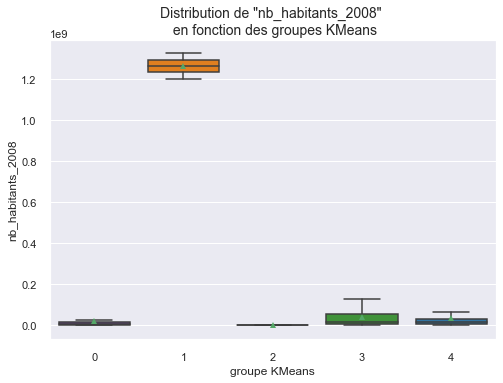

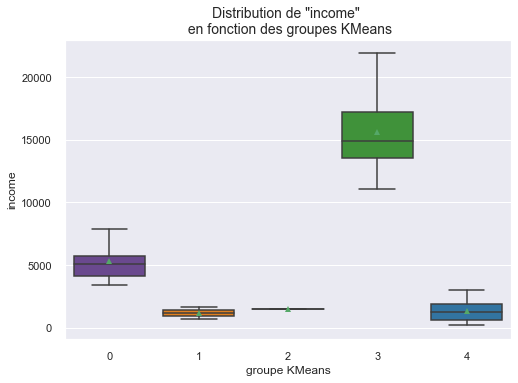

In [40]:
# variables quantitatives :
quanti = ['nb_habitants_2008','income']

for variable in quanti:
    sns.boxplot(data=df_revenu_median_gpeK_clt, x='cluster', y=variable, palette= 'Paired_r', showmeans=True, showfliers=False)
    plt.title(f'Distribution de "{variable}" \n en fonction des groupes KMeans', size=14)
    plt.ylabel(f'{variable}', size= 12)
    plt.xlabel('groupe KMeans', size=12)
    plt.show()

### Les groupes sont-ils distincts ? <a class="anchor" id="gpe_distincts"></a>

#### Test de Kolmogorov_Smirnov pour tester la normalité des variables

Hypothèses :
- H0 : la variable suit une loi normale
- H1 : la variable ne suit pas une loi normale
- Seuil 5%

In [41]:
for variable in quanti :
    print(f'{variable :-<32}{ks_2samp_test(variable, df_revenu_median_gpeK_clt)}\n')

p_value :1.1127765375817944e-12
nb_habitants_2008---------------HO rejetée, la variable nb_habitants_2008 ne suit pas une loi normale

p_value :7.795635783236499e-06
income--------------------------HO rejetée, la variable income ne suit pas une loi normale



#### Test de Levène d'égalité des variances

Hypothèses :
- HO : les variances sont égales
- H1 : les variances ne sont pas égales
- seuil alpha = 0.05

In [42]:
for variable in quanti:
    gpe1 = df_revenu_median_gpeK_clt[df_revenu_median_gpeK_clt['cluster']== 1][variable]
    gpe2 = df_revenu_median_gpeK_clt[df_revenu_median_gpeK_clt['cluster']== 4][variable]
    print(f'{variable :-<20}{levene_test(gpe1, gpe2)}\n') 

p_value :0.2736513226662239
nb_habitants_2008---HO ne peut pas être rejetée, les variances des 2 groupes sont égales

p_value :0.4865843566359629
income--------------HO ne peut pas être rejetée, les variances des 2 groupes sont égales



#### Test de Student sur l'égalité des moyennes

#### Hypothèses :
- H0 : m4 = m5
- H1 : m4 != m5
- seuil alpha = 0.05

In [43]:
for variable in quanti:        
    gpe1 = df_revenu_median_gpeK_clt[df_revenu_median_gpeK_clt['cluster']== 1][variable]
# Pour avoir la même dimension d'échantillon
    gpe2_sample = df_revenu_median_gpeK_clt[df_revenu_median_gpeK_clt['cluster']== 4][variable].sample(gpe1.shape[0])
    print(f'{variable :-<20}{student_test(gpe2_sample, gpe1)}\n') 

p_value :0.002685679325982925
nb_habitants_2008---HO rejetée, les moyennes des 2 groupes sont inégales

p_value :0.44526033709127144
income--------------HO ne peut pas être rejetée, les moyennes des 2 groupes sont égales



#### Remarque : les groupes sont dictincts

### ACP <a class="anchor" id="acp"></a>

In [44]:
df_distrib_revenus.head(1)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country
0,ALB,2008,1,100,728.89795,7297.0,Albania


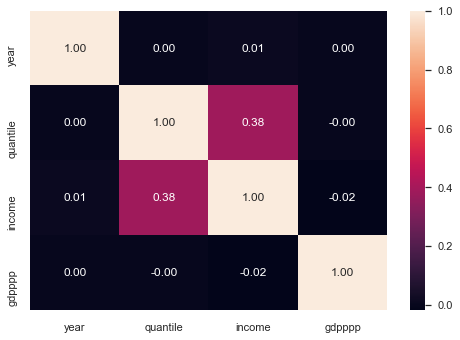

In [45]:
# Corrélation entre le prix et la catégorie 
df_revenu_corr = df_distrib_revenus.drop(['nb_quantiles'], axis=1)
sns.heatmap(df_revenu_corr.corr(), annot=True, fmt=".2f")
plt.show()

#### Remarque : les variables ne sont pas corrélées entre elles

In [46]:
# préparation des données pour l'ACP 
df_revenu_median_gpeK_acp = df_revenu_median_gpeK_clt[['nb_habitants_2008', 'income', 'gdpppp']]
df_revenu_median_gpeK_acp = df_revenu_median_gpeK_acp.fillna(df_revenu_median_gpeK_acp.mean())
GK = df_revenu_median_gpeK_acp.values
names = df_revenu_median_gpeK_clt['country']
features = df_revenu_median_gpeK_acp.columns

In [47]:
features

Index(['nb_habitants_2008', 'income', 'gdpppp'], dtype='object')

In [48]:
# Centrage et réduction des données
std_scale = StandardScaler().fit(GK)
X_scaled_K = std_scale.transform(GK)

In [49]:
# Vérification moyenne
np.mean(X_scaled_K, axis=0)

array([ 2.49441272e-17,  2.39272204e-17, -1.26814268e-17])

In [50]:
# Vérification moyenne
np.std(X_scaled_K, axis=0)

array([1., 1., 1.])

In [51]:
# Nombre de composantes
n_comp = 3

In [52]:
# Calcul des composantes principales
cluster_pca = PCA(n_components=n_comp)
cluster_pca.fit(X_scaled_K)

PCA(n_components=3)

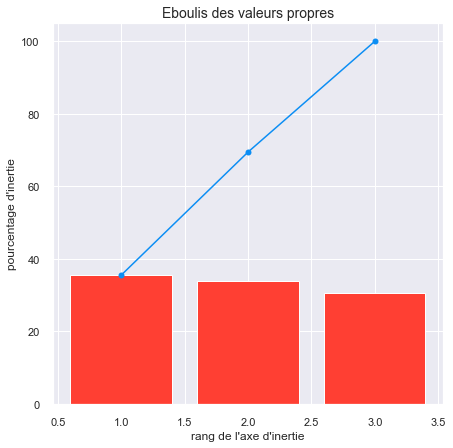

In [53]:
# Eboulis des valeurs propres
display_scree_plot(cluster_pca)
plt.savefig("eboulis acp clustersK.jpg")

#### Remarque : confirmation que les variables ne sont pas corrélées

In [54]:
# Calcul des composantes principales
cluster_pca = PCA(n_components=n_comp)
X_reduced = cluster_pca.fit_transform(X_scaled_K)

In [55]:
X_centroide = res.cluster_centers_
X_centroide

array([[-0.196789  ,  0.07292591, -0.08607217],
       [ 7.20870071, -0.65582983, -0.11385372],
       [-0.31379924, -0.60555776, 10.71794741],
       [-0.06974016,  1.88993795, -0.03621347],
       [-0.11590294, -0.62855402, -0.11426878]])

In [56]:
df_revenu_median_gpeK_clt

,country,nb_habitants_2008,income,gdpppp,cluster
0,Albania,2947314.0,2493.83700,7297.00000,4
1,Argentina,40080159.0,4132.66550,13220.00000,0
2,Armenia,2907615.0,1428.15540,5611.00000,4
3,Austria,8321496.0,14569.91700,36193.00000,3
4,Azerbaijan,8763400.0,1939.94010,8101.00000,4
...,...,...,...,...,...
111,Vietnam,86243424.0,1031.81400,2578.00000,4
112,West Bank and Gaza,3591977.0,866.13873,2900.00000,4
113,"Yemen, Rep.",21892149.0,786.60210,2224.00000,4
114,South Africa,49779472.0,2030.94200,9602.00000,4


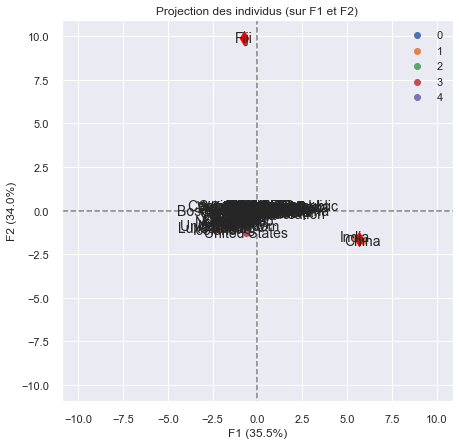

In [57]:
# Projection des individus
X_projected = cluster_pca.transform(X_scaled_K)
display_factorial_planes(X_projected, n_comp, cluster_pca, [(0,1)], illustrative_var=df_revenu_median_gpeK_clt.cluster, labels = names, centroid=X_centroide)
# plt.savefig("proj individus_labels gpeK.jpg")

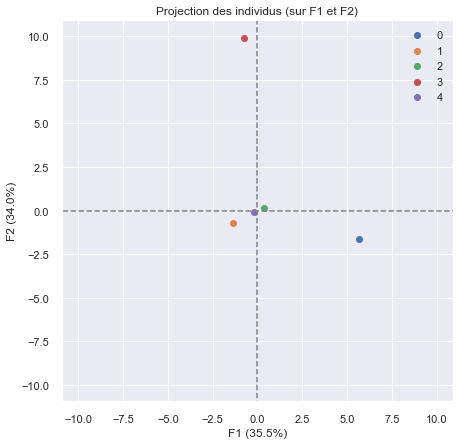

In [58]:
# Projection des nouveaux centroïdes
X_projected_c = cluster_pca.transform(X_centroide)
display_factorial_planes(X_projected_c, n_comp, cluster_pca, [(0,1)], illustrative_var=df_revenu_median_gpeK_clt.cluster.unique())

#### Remarque :
- 2 outliers : Chine/Inde et Fidji
- On retire ces 2 groupes et on refait un KMeans pour un clustering plus fin

### Retrait des 2 outliers pour un nouveau KMeans <a class="anchor" id="reKMeans"></a>

In [59]:
df_re_Kmeans_I = df_revenu_median_gpeK.copy()
df_re_Kmeans = df_re_Kmeans_I.reset_index()
df_re_Kmeans.head(2)

,country,nb_habitants_2008,income,gdpppp
0,Albania,2947314.0,2493.8370,7297.0
1,Argentina,40080159.0,4132.6655,13220.0


In [60]:
df_re_Kmeans.shape

(116, 4)

In [61]:
outliers = ['China', 'India', 'Fiji']
for pays in outliers :
    df_re_Kmeans.drop(df_re_Kmeans[df_re_Kmeans['country'] == pays].index, inplace=True)

In [62]:
df_re_Kmeans.shape

(113, 4)

#### Clustering KMeans sur le dataframe sans outliers

In [63]:
df_re_Kmeans_Ibis = df_re_Kmeans.set_index('country')

In [64]:
df_re_Kmeans_Ibis.head(2)

,nb_habitants_2008,income,gdpppp
country,,,
Albania,2947314.0,2493.8370,7297.0
Argentina,40080159.0,4132.6655,13220.0


In [65]:
# préparation des données pour le clustering
XmediaRK = df_re_Kmeans_Ibis.values
names = df_re_Kmeans_Ibis.index

In [66]:
#  Standardisation des données
scalerBis = StandardScaler()
X_scaledMediaRK = scalerBis.fit_transform(XmediaRK)

In [67]:
# Vérification de la standardisation
X_scaledMediaRK.mean(axis=0)

array([-9.82498252e-19, -6.38623864e-17,  4.12649266e-17])

In [68]:
# Vérification de la réduction
X_scaledMediaRK.std(axis=0)

array([1., 1., 1.])

In [69]:
nb_clusterR = 4

In [70]:
# Clustering sans les outliers
resBis = cluster.KMeans(n_clusters=nb_clusterR,random_state = 42)
resBis.fit(X_scaledMediaRK)

KMeans(n_clusters=4, random_state=42)

In [71]:
# Recherche du nombre de clusters optimal
# Décroissance de l'inertie interclasse (k:clusters)
# visualizer = KElbowVisualizer(resBis, k=(1,12), timings=False)
# visualizer.fit(X_scaledMediaRK)
# visualizer.show()  
# plt.savefig("elbow gpeKmeans.jpg")

In [72]:
# Ajout des groupes au dataframe
df_re_Kmeans_I_clt = df_re_Kmeans_Ibis.copy()
df_re_Kmeans_I_clt['cluster'] = resBis.labels_ 

In [73]:
gb = df_re_Kmeans_I_clt.groupby(resBis.labels_ )

#### Etude des nouveaux groupes <a class="anchor" id="reetude_gpe"></a>

In [74]:
gb.size()

0    80
1    25
2     7
3     1
dtype: int64

In [75]:
gb.mean()

,nb_habitants_2008,income,gdpppp,cluster
0,1.964829e+07,2153.108614,6333.889984,0
1,2.617898e+07,14359.875548,33033.000000,1
2,1.638972e+08,1882.610540,6708.857143,2
3,3.040940e+08,18981.207000,43261.000000,3


In [76]:
df_re_Kmeans_I_clt[df_re_Kmeans_I_clt['cluster'] == 0].head(5)

,nb_habitants_2008,income,gdpppp,cluster
country,,,,
Albania,2947314.0,2493.8370,7297.0000,0
Argentina,40080159.0,4132.6655,13220.0000,0
Armenia,2907615.0,1428.1554,5611.0000,0
Azerbaijan,8763400.0,1939.9401,8101.0000,0
Burkina Faso,14689725.0,659.5971,1085.5139,0


#### Remarque :
- gpe 0 : moyenne basse (Argentine, Burkina Faso...)
- gpe 1 : income fort, gdp ppp fort (Europe, Canada...)
- gpe 2 : (Bangladesh, Mexico, Nigeria...)
- gpe 3 : outlier : nb_habitants_2008 le plus fort, income le plus fort, gdp ppp le plus fort (USA) 

#### Visualisation des variables en fonction des groupes

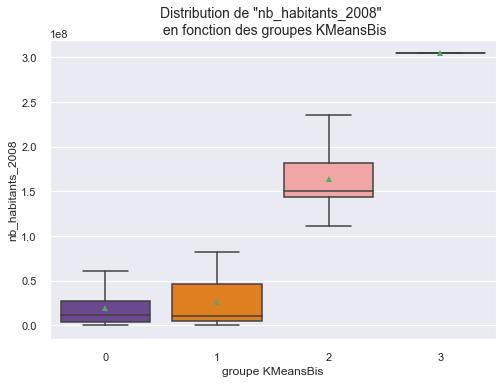

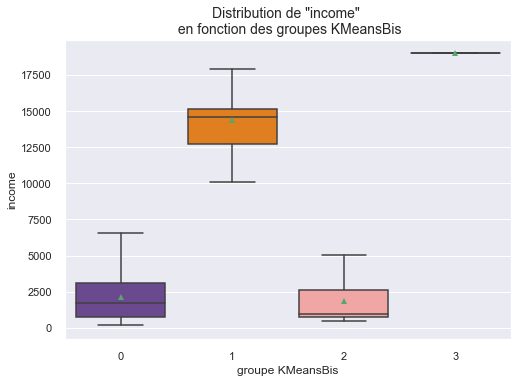

In [77]:
# variables quantitatives :
quanti = ['nb_habitants_2008','income']

for variable in quanti:
    sns.boxplot(data=df_re_Kmeans_I_clt, x='cluster', y=variable, palette= 'Paired_r', showmeans=True, showfliers=False)
    plt.title(f'Distribution de "{variable}" \n en fonction des groupes KMeansBis', size=14)
    plt.ylabel(f'{variable}', size= 12)
    plt.xlabel('groupe KMeansBis', size=12)
    
    plt.show()

### Les groupes sont-ils distincts ? 

#### Test de Levène d'égalité des variables

Hypothèses :
- HO : les variances sont égales
- H1 : les variances ne sont pas égales
- seuil alpha = 0.05

In [78]:
for variable in quanti:
    gpe1 = df_re_Kmeans_I_clt[df_re_Kmeans_I_clt['cluster']== 0][variable]
    gpe2 = df_re_Kmeans_I_clt[df_re_Kmeans_I_clt['cluster']== 1][variable]
    print(f'{variable :-<20}{levene_test(gpe1, gpe2)}\n') 

p_value :0.19173971508026136
nb_habitants_2008---HO ne peut pas être rejetée, les variances des 2 groupes sont égales

p_value :9.283783526811827e-05
income--------------HO rejetée, les variances des 2 groupes sont inégales



#### Remarque : les groupes sont distincts

#### Test de Student d'égalité des moyennes

Hypothèses :
- HO : les moyennes sont égales
- H1 : les moyennes ne sont pas égales
- seuil alpha = 0.05

In [79]:
for variable in quanti:        
    gpe1 = df_re_Kmeans_I_clt[df_re_Kmeans_I_clt['cluster']== 1][variable]
# Pour avoir la même dimension d'échantillon
    gpe2_sample = df_re_Kmeans_I_clt[df_re_Kmeans_I_clt['cluster']== 0][variable].sample(gpe1.shape[0])
    print(f'{variable :-<20}{student_test(gpe2_sample, gpe1)}\n') 

p_value :0.516934832211353
nb_habitants_2008---HO ne peut pas être rejetée, les moyennes des 2 groupes sont égales

p_value :6.696298472446043e-18
income--------------HO rejetée, les moyennes des 2 groupes sont inégales



### ACP sur le nouveau clustering <a class="anchor" id="reacp"></a>

In [80]:
df_re_Kmeans_clt = df_re_Kmeans_I_clt.reset_index()

In [81]:
# préparation des données pour l'ACP 
df_re_Kmeans_clt_acpV = df_re_Kmeans_clt[['nb_habitants_2008', 'income', 'gdpppp']]
df_re_Kmeans_clt_acpV = df_re_Kmeans_clt_acpV.fillna(df_re_Kmeans_clt_acpV.mean())
GKBis = df_re_Kmeans_clt_acpV.values
names = df_re_Kmeans_clt['country']
features = df_re_Kmeans_clt_acpV.columns

In [82]:
# Centrage et réduction des données
std_scaleB = StandardScaler().fit(GKBis)
X_scaled_KB = std_scaleB.transform(GKBis)

In [83]:
n_compBis = 2

In [84]:
# Calcul des composantes principales
cluster_pcaB = PCA(n_components=n_compBis)
X_reducedB = cluster_pcaB.fit_transform(X_scaled_KB)

In [85]:
X_centroideB = resBis.cluster_centers_
X_centroideB

array([[-0.25929059, -0.4940919 , -0.47280965],
       [-0.12800133,  1.6350079 ,  1.54473867],
       [ 2.6406058 , -0.54127207, -0.44447483],
       [ 5.45903951,  2.44105884,  2.31762901]])

In [86]:
df_re_Kmeans_I_clt[df_re_Kmeans_I_clt['cluster'] == 0].head(5)

,nb_habitants_2008,income,gdpppp,cluster
country,,,,
Albania,2947314.0,2493.8370,7297.0000,0
Argentina,40080159.0,4132.6655,13220.0000,0
Armenia,2907615.0,1428.1554,5611.0000,0
Azerbaijan,8763400.0,1939.9401,8101.0000,0
Burkina Faso,14689725.0,659.5971,1085.5139,0


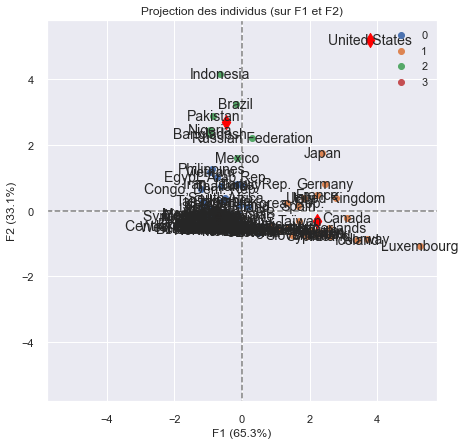

In [87]:
# Projection des individus
X_projectedB = cluster_pcaB.transform(X_scaled_KB)
display_factorial_planes(X_projectedB, n_compBis, cluster_pcaB, [(0,1)], illustrative_var=df_re_Kmeans_I_clt.cluster, centroid=X_centroideB, labels = names)
# plt.savefig("proj individus_labels gpeK.jpg")
# labels = names,

#### Les USA se démarquent dans ce nouveau clustering

Qualité de représentation des pays

In [88]:
df_re_Kmeans_clt.head(1)

,country,nb_habitants_2008,income,gdpppp,cluster
0,Albania,2947314.0,2493.837,7297.0,0


In [89]:
# Contribution des individus dans l'inertie totale
di = np.sum(X_scaled_KB**2,axis=1)
df_contribution = pd.DataFrame({'country':df_re_Kmeans_clt.country,'d_i':di})
df_contribution.head(2)

,country,d_i
0,Albania,0.703025
1,Argentina,0.047348


In [90]:
# Qualité de représentation des pays - COS2 de l’angle qu’il forme avec sa projection sur les différents axes  
cos2 = X_reducedB**2

for j in range(n_compBis):
    cos2[:,j] = cos2[:,j]/di
qualite_representPays = pd.DataFrame({'country':df_re_Kmeans_clt.country,'COS2_F1':cos2[:,0],'COS2_F2':cos2[:,1],
                                      'cluster' : df_re_Kmeans_clt.cluster})
print("Qualité de représentation des pays par axe :\n", qualite_representPays)

Qualité de représentation des pays par axe :
                 country   COS2_F1   COS2_F2  cluster
0               Albania  0.573766  0.425799        0
1             Argentina  0.074937  0.506790        0
2               Armenia  0.719648  0.276941        0
3               Austria  0.925129  0.074038        1
4            Azerbaijan  0.677604  0.295312        0
..                  ...       ...       ...      ...
108             Vietnam  0.394768  0.604721        0
109  West Bank and Gaza  0.820429  0.179379        0
110         Yemen, Rep.  0.984887  0.013898        0
111        South Africa  0.562092  0.337669        0
112    Congo, Dem. Rep.  0.768171  0.230098        0

[113 rows x 4 columns]


In [91]:
df_re_Kmeans_clt.head(1)

,country,nb_habitants_2008,income,gdpppp,cluster
0,Albania,2947314.0,2493.837,7297.0,0


In [92]:
df_re_Kmeans_clt[df_re_Kmeans_clt['country']=='Uganda']

,country,nb_habitants_2008,income,gdpppp,cluster
103,Uganda,30431734.0,676.09125,1067.0,0


### Calcul de la qualité de représentation des différents pays <a class="anchor" id="qual_pays"></a>
- recherche du pays le mieux représenté pour chaque cluster

In [93]:
qualite_representPays = qualite_representPays.copy()

In [94]:
for i in range(0,4):
    qualite_representPays = pd.DataFrame({'country':df_re_Kmeans_clt.country,'COS2_F1':cos2[:,0],'COS2_F2':cos2[:,1],
                                      'cluster' : df_re_Kmeans_clt.cluster})
    
    qualite_representPays = qualite_representPays[qualite_representPays['cluster']== i]
    qualite_representPays.drop('cluster', axis=1, inplace=True)
    qual_rep_pays_F1 = qualite_representPays.sort_values('COS2_F1', ascending=False).head(5)
    qual_rep_pays_F2 = qualite_representPays.sort_values('COS2_F2', ascending=False).head(5)
    qual_rep_pays_F1.set_index('country', inplace=True)
    print('cluster {} sur F1 : \n'.format(i))    
    print(qual_rep_pays_F1)
    print('cluster {} sur F2 : \n'.format(i))
    print(qual_rep_pays_F2)
    

cluster 0 sur F1 : 

          COS2_F1   COS2_F2
country                    
Iraq     0.996639  0.000069
Morocco  0.993392  0.003118
Nepal    0.992890  0.000555
Uganda   0.992863  0.001791
Ghana    0.992163  0.005886
cluster 0 sur F2 : 

                country   COS2_F1   COS2_F2
100              Turkey  0.001152  0.998024
43   Iran, Islamic Rep.  0.031519  0.968328
61               Latvia  0.072024  0.909920
68           Montenegro  0.011059  0.895939
8              Bulgaria  0.114689  0.867873
cluster 1 sur F1 : 

                 COS2_F1   COS2_F2
country                           
Spain           0.992380  0.006987
United Kingdom  0.958473  0.017700
Netherlands     0.958034  0.040347
Canada          0.956050  0.004918
Italy           0.952941  0.042598
cluster 1 sur F2 : 

           country   COS2_F1   COS2_F2
49           Japan  0.647410  0.347500
85        Portugal  0.703939  0.274677
22  Czech Republic  0.660808  0.262996
46          Israel  0.743131  0.218617
93        Sloven

cluster 0 sur F1 : 

          COS2_F1   COS2_F2
country                    
Iraq     0.996639  0.000069
Morocco  0.993392  0.003118
Nepal    0.992890  0.000555
Uganda   0.992863  0.001791
Ghana    0.992163  0.005886


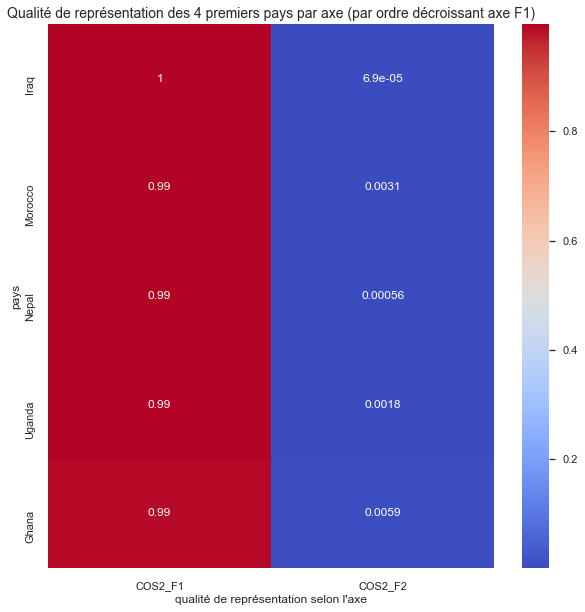

cluster 1 sur F1 : 

                 COS2_F1   COS2_F2
country                           
Spain           0.992380  0.006987
United Kingdom  0.958473  0.017700
Netherlands     0.958034  0.040347
Canada          0.956050  0.004918
Italy           0.952941  0.042598


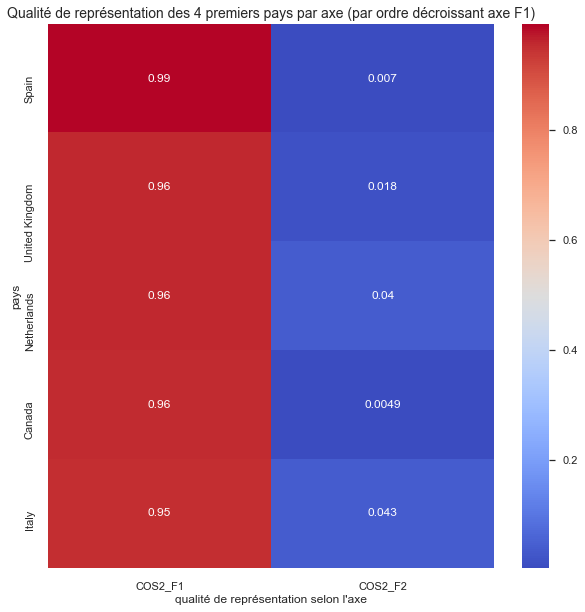

cluster 2 sur F1 : 

                     COS2_F1   COS2_F2
country                               
Bangladesh          0.141003  0.858389
Nigeria             0.127991  0.871957
Pakistan            0.080840  0.919140
Indonesia           0.023753  0.975980
Russian Federation  0.017811  0.978415


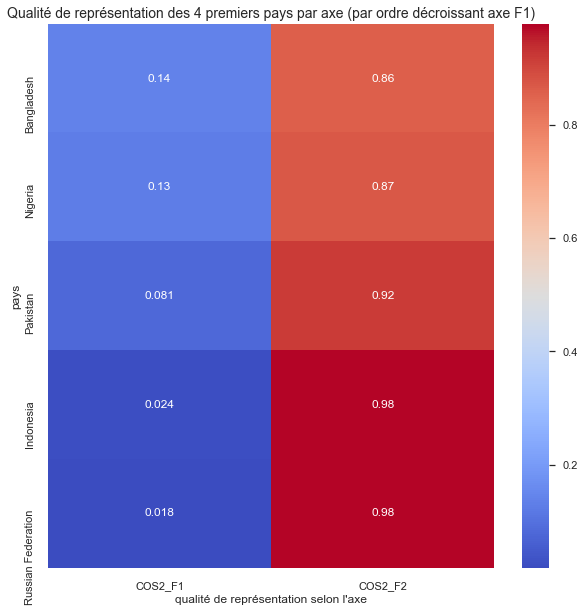

cluster 3 sur F1 : 

               COS2_F1   COS2_F2
country                         
United States  0.34795  0.652038


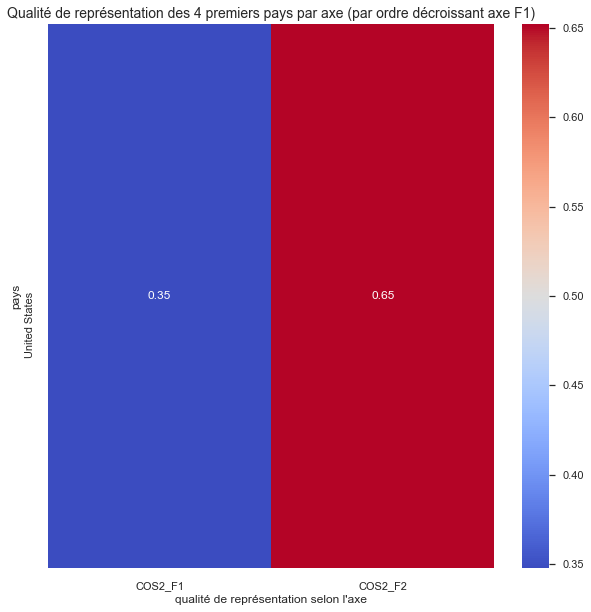

In [95]:
# Heatmap des la qualité représentation des pays pour chaque cluster
for i in range(0,4):
    qualite_representPays = pd.DataFrame({'country':df_re_Kmeans_clt.country,'COS2_F1':cos2[:,0],'COS2_F2':cos2[:,1],
                                      'cluster' : df_re_Kmeans_clt.cluster})
    qualite_representPays = qualite_representPays[qualite_representPays['cluster']== i]
    qualite_representPays.drop('cluster', axis=1, inplace=True)
    qual_rep_pays_F1 = qualite_representPays.sort_values('COS2_F1', ascending=False).head(5)
    qual_rep_pays_F1.set_index('country', inplace=True)
    print('cluster {} sur F1 : \n'.format(i))   
    print(qual_rep_pays_F1)

    plt.figure(figsize=(10,10))
    sns.heatmap(qual_rep_pays_F1, cmap='coolwarm', annot=True, annot_kws={'size':12})
    plt.ylabel('pays', size= 12)
    plt.xlabel('qualité de représentation selon l\'axe', size= 12)
    plt.title('Qualité de représentation des 4 premiers pays par axe (par ordre décroissant axe F1)', size=14)
    plt.show()

### Pays retenus pour l'analyse <a class="anchor" id="pays_retenus"></a>

- Iraq gpe0
- Spain gpe1 ???
- Bangladesh gpe2
- USA gpe3
- China gpe4
- France

In [96]:
# df_re_Kmeans_cltI = df_re_Kmeans_clt.set_index('country')

In [97]:
# valeur corrigée
# n = df_re_Kmeans_clt.shape[0]
# eigval = (n-1)/n*resBis.explained_variance_
# print(eigval)

In [98]:
# #contributions aux axes
# ctr = X_reducedB**2
# for j in range(n_compBis):
#     ctr[:,j] = ctr[:,j]/(n*eigval[j]) 
# contributionAxes = pd.DataFrame({'pays':df_re_Kmeans_clt.country,'CTR_F1':ctr[:,0],'CTR_F2':ctr[:,1],
#                                 'cluster' : df_re_Kmeans_clt.cluster})
# print("Contributions aux axes :\n", contributionAxes)

In [99]:
# contributionAxes = contributionAxes.copy()

In [100]:
# # Heatmap des la qualité représentation des pays pour chaque cluster
# for i in range(0,4):
   
#     contributionAxes = pd.DataFrame({'pays':df_re_Kmeans_clt.country,'CTR_F1':ctr[:,0],'CTR_F2':ctr[:,1],
#                                     'cluster' : df_re_Kmeans_clt.cluster})
#     contributionAxes = contributionAxes[contributionAxes['cluster']== i]
#     contributionAxes.drop('cluster', axis=1, inplace=True)
#     contributionAxes_F1 = contributionAxes.sort_values('CTR_F1', ascending=False).head(5)
#     contributionAxes_F1.set_index('pays', inplace=True)
#     contributionAxes_F2 = contributionAxes.sort_values('CTR_F2', ascending=False).head(5)
#     contributionAxes_F2.set_index('pays', inplace=True)
#     print(contributionAxes_F1)
#     print(contributionAxes_F2)

#     plt.figure(figsize=(10,10))
#     sns.heatmap(contributionAxes_F1, cmap='coolwarm', annot=True, annot_kws={'size':12})
#     plt.ylabel('pays', size= 12)
#     plt.xlabel('contribution selon l\'axe', size= 12)
#     plt.title('Contribution des 10 premiers individus par axe (par ordre décroissant axe F1)', size=14)
#     plt.show()
#     sns.heatmap(contributionAxes_F2, cmap='coolwarm', annot=True, annot_kws={'size':12})
#     plt.ylabel('pays', size= 12)
#     plt.xlabel('contribution selon l\'axe', size= 12)
#     plt.title('Contribution des 10 premiers individus par axe (par ordre décroissant axe F2)', size=14)
#     plt.show()

- Iraq gpe0
- Spain gpe1 ???
- Bangladesh gpe2
- USA gpe3
- China gpe4
- France

### Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour les 6 pays choisis pour montrer la diversité des cas 
<a class="anchor" id="diversite_pays"></a>

In [101]:
pays_choisis = ['Bangladesh', 'China', 'France' , 'Iraq', 'Spain', 'United States']

In [102]:
df_revenus_pop.head(2)

,country_code,nb_habitants_2008,year,quantile,nb_quantiles,income,gdpppp,country
0,ALB,2947314.0,2008,1,100,728.89795,7297.0,Albania
1,ALB,2947314.0,2008,2,100,916.66235,7297.0,Albania


In [103]:
df_pays_choisis = df_revenus_pop[df_revenus_pop['country'].isin(pays_choisis)]
df_pays_choisis.shape

(600, 8)

In [104]:
df_pays_choisis.describe(include='all')

,country_code,nb_habitants_2008,year,quantile,nb_quantiles,income,gdpppp,country
count,600,6.000000e+02,600.000000,600.000000,600.0,600.000000,600.000000,600
unique,6,NaN,NaN,NaN,NaN,NaN,NaN,6
top,USA,NaN,NaN,NaN,NaN,NaN,NaN,United States
freq,100,NaN,NaN,NaN,NaN,NaN,NaN,100
mean,NaN,3.186280e+08,2008.166667,50.500000,100.0,10359.490932,18678.333333,NaN
std,NaN,4.597173e+08,0.898276,28.890155,0.0,15234.680967,16070.130752,NaN
min,NaN,2.838574e+07,2007.000000,1.000000,100.0,16.719418,1233.000000,NaN
25%,NaN,4.595411e+07,2008.000000,25.750000,100.0,1137.490625,3171.000000,NaN
50%,NaN,1.043396e+08,2008.000000,50.500000,100.0,4865.976350,17024.000000,NaN
75%,NaN,3.040940e+08,2008.000000,75.250000,100.0,14555.546500,30357.000000,NaN


In [105]:
# Valeur null => pas de valeurs null
df_pays_choisis.isnull().sum().any()

False

In [106]:
#  valeurs dupliquées
df_pays_choisis.duplicated().sum()

0

#### Visualisation de la diversité des pays choisis en termes de distribution de revenus

In [107]:
df_pays_choisis[df_pays_choisis['quantile']== 10]

,country_code,nb_habitants_2008,year,quantile,nb_quantiles,income,gdpppp,country
709,BGD,1.443042e+08,2010,10,100,454.56052,1233.0,Bangladesh
1709,CHN,1.324655e+09,2007,10,100,505.89682,5712.0,China
2909,ESP,4.595411e+07,2008,10,100,5131.09600,28336.0,Spain
3309,FRA,6.437498e+07,2008,10,100,7419.52300,30357.0,France
4709,IRQ,2.838574e+07,2008,10,100,632.17600,3171.0,Iraq
10909,USA,3.040940e+08,2008,10,100,5815.52640,43261.0,United States


In [108]:
df_pays_choisis.year.unique()

array([2010, 2007, 2008], dtype=int64)

#### Visualisation de la distribution des revenus pour les pays choisis <a class="anchor" id="graph_diversite_pays"></a>

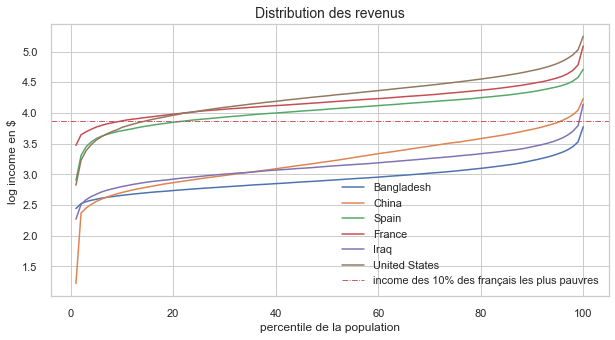

In [109]:
# années représentées (2007, 2008, 2010)
plt.figure(figsize=(10,5))
# sns.set_theme(style="white")
sns.set_theme(style="whitegrid")
sns.lineplot(x="quantile", y= np.log10(df_pays_choisis['income']),
             hue="country", data=df_pays_choisis)
plt.axhline(y = np.log10(7419.52300), color ="r", linestyle ="-.",linewidth=0.9, 
            label='income des 10% des français les plus pauvres')
# plt.axhline(0, label ='Line3', color ='black') 
# plt.hlines(y, xmin, xmax, colors=None, linestyles='solid', label='', *, data=None, **kwargs)
plt.title('Distribution des revenus', size=14)
plt.xlabel('percentile de la population', size=12)
plt.ylabel('log income en $ ')
plt.legend() 
plt.savefig("Distribution des revenus.jpg")
# plt.show()

#### Remarques :
- les 10% plus pauvres français sont plus riches que les ~ 5% des plus riches chinois...
- les 20% des plus pauvres français sont plus riches que les 20 % des plus pauvres américains puis inversion des courbes
- les 80% des plus riches américains sont plus riches que les 80% français les plus riches

### Courbes de Lorentz pour les pays choisis <a class="anchor" id="lorentz_pays"></a>

In [110]:
df_pays_choisis.head(5)

,country_code,nb_habitants_2008,year,quantile,nb_quantiles,income,gdpppp,country
700,BGD,144304164.0,2010,1,100,276.93503,1233.0,Bangladesh
701,BGD,144304164.0,2010,2,100,332.78653,1233.0,Bangladesh
702,BGD,144304164.0,2010,3,100,359.20620,1233.0,Bangladesh
703,BGD,144304164.0,2010,4,100,377.34985,1233.0,Bangladesh
704,BGD,144304164.0,2010,5,100,392.61746,1233.0,Bangladesh


In [111]:
df_pays_choisis[df_pays_choisis['country'] == 'China']

,country_code,nb_habitants_2008,year,quantile,nb_quantiles,income,gdpppp,country
1700,CHN,1.324655e+09,2007,1,100,16.719418,5712.0,China
1701,CHN,1.324655e+09,2007,2,100,234.150730,5712.0,China
1702,CHN,1.324655e+09,2007,3,100,282.894900,5712.0,China
1703,CHN,1.324655e+09,2007,4,100,323.826500,5712.0,China
1704,CHN,1.324655e+09,2007,5,100,362.260600,5712.0,China
...,...,...,...,...,...,...,...,...
1795,CHN,1.324655e+09,2007,96,100,7588.195000,5712.0,China
1796,CHN,1.324655e+09,2007,97,100,8317.553000,5712.0,China
1797,CHN,1.324655e+09,2007,98,100,9382.284000,5712.0,China
1798,CHN,1.324655e+09,2007,99,100,11071.510000,5712.0,China


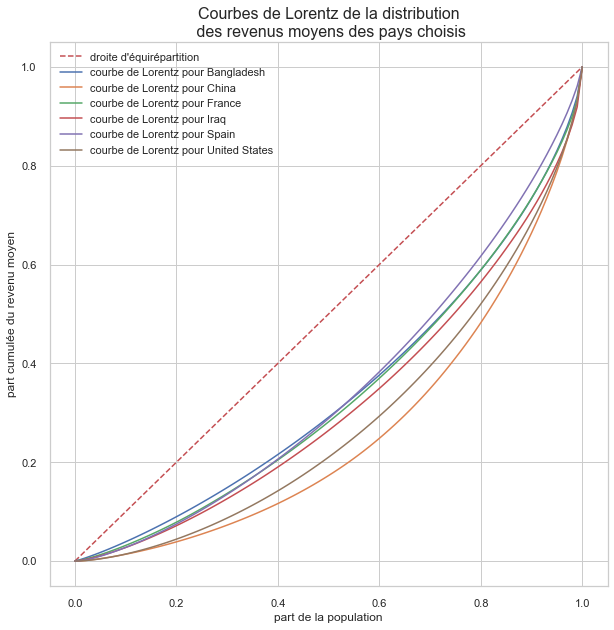

In [112]:
multi_courbeLorentz(df_pays_choisis, pays_choisis, 'part de la population', 'part cumulée du revenu moyen', 'Courbes de Lorentz de la distribution\n des revenus moyens des pays choisis')


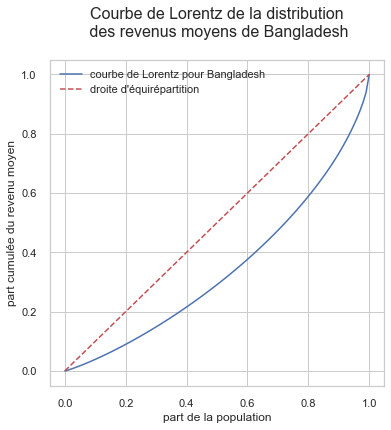

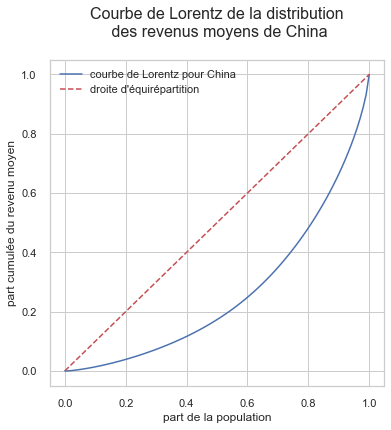

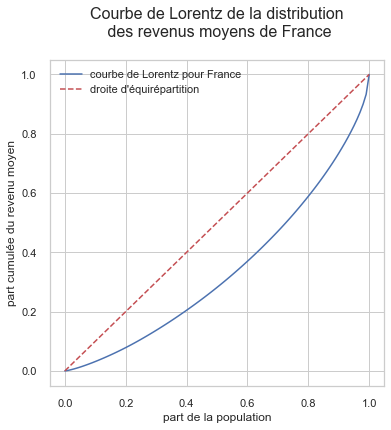

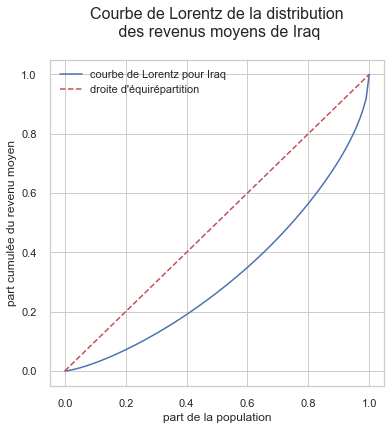

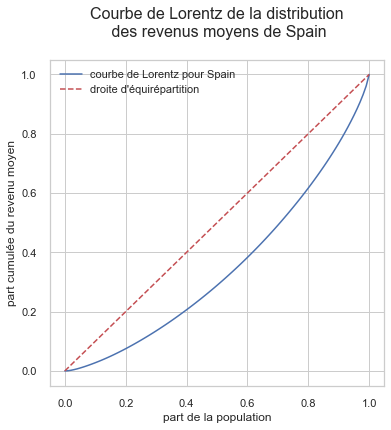

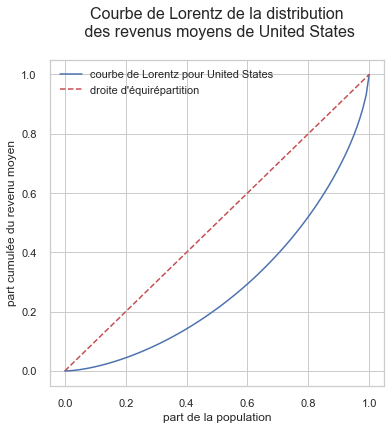

In [113]:
for pays in pays_choisis :
    lo = df_pays_choisis.loc[df_pays_choisis['country'] == pays, 'income']
    courbeLorentz(lo, 'part de la population', 'part cumulée du revenu moyen', 
                   f'courbe de Lorentz pour {pays}', f'Courbe de Lorentz de la distribution\n des revenus moyens de {pays}\n')

#### Remarques 
- la chine et les USA sont les plus inégalitaires des pays choisis
- la France l'est moins

### Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans 
<a class="anchor" id="gini_pays"></a>

### Importation et lecture des données d'indices de Gini <a class="anchor" id="import_gini"></a>

In [114]:
colum = ['Country Name', 'Country Code', '2004', '2006', '2007', '2008', '2009', '2010', '2011']
df_gini = pd.read_csv('WOLD_BANK_gini.csv', encoding= ENCODAGE, sep=',', skiprows=4, usecols=colum, decimal=',').copy()
df_gini.head(2)

,Country Name,Country Code,2004,2006,2007,2008,2009,2010,2011
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
df_gini.shape

(266, 9)

In [116]:
df_gini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country Name  266 non-null    object
 1   Country Code  266 non-null    object
 2   2004          70 non-null     object
 3   2006          75 non-null     object
 4   2007          70 non-null     object
 5   2008          73 non-null     object
 6   2009          78 non-null     object
 7   2010          83 non-null     object
 8   2011          77 non-null     object
dtypes: object(9)
memory usage: 18.8+ KB


In [117]:
variables = ['2004', '2006', '2007', '2008', '2009','2010', '2011']
for var in variables :
    df_gini[var] = df_gini[var].astype(float)

In [118]:
# renommage des colonnes
df_gini.columns = ['country', 'country_code', '2004', '2006', '2007', '2008', '2009', '2010', '2011']

In [119]:
df_gini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       266 non-null    object 
 1   country_code  266 non-null    object 
 2   2004          70 non-null     float64
 3   2006          75 non-null     float64
 4   2007          70 non-null     float64
 5   2008          73 non-null     float64
 6   2009          78 non-null     float64
 7   2010          83 non-null     float64
 8   2011          77 non-null     float64
dtypes: float64(7), object(2)
memory usage: 18.8+ KB


In [120]:
# récupération des données concernant les pays choisis
df_pays_choisis_gini = df_gini[df_gini['country'].isin(pays_choisis)]
df_pays_choisis_gini.shape

(6, 9)

In [121]:
df_pays_choisis_gini.head()

,country,country_code,2004,2006,2007,2008,2009,2010,2011
20,Bangladesh,BGD,NaN,NaN,NaN,NaN,NaN,32.1,NaN
40,China,CHN,NaN,NaN,NaN,43.0,NaN,43.7,42.4
70,Spain,ESP,33.3,33.5,34.1,34.2,34.9,35.2,35.7
77,France,FRA,30.6,29.7,32.4,33.0,32.7,33.7,33.3
113,Iraq,IRQ,NaN,28.6,NaN,NaN,NaN,NaN,NaN


In [122]:
df_pays_choisis_gini.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 20 to 251
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       6 non-null      object 
 1   country_code  6 non-null      object 
 2   2004          3 non-null      float64
 3   2006          4 non-null      float64
 4   2007          3 non-null      float64
 5   2008          4 non-null      float64
 6   2009          3 non-null      float64
 7   2010          5 non-null      float64
 8   2011          4 non-null      float64
dtypes: float64(7), object(2)
memory usage: 480.0+ bytes


#### Visualisation du nombre d'indices de Gini manquants dans le fichier importé

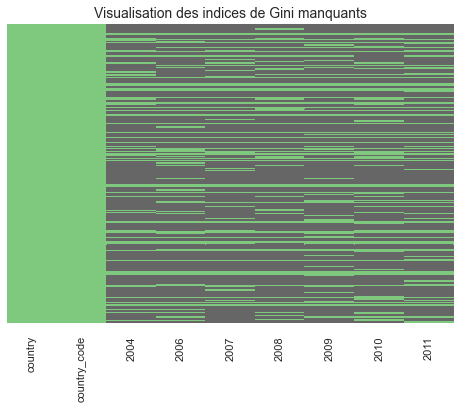

In [123]:
sns.heatmap(df_gini.isnull(),yticklabels=False, cbar=False,cmap='Accent')
plt.title("Visualisation des indices de Gini manquants", size=14)
plt.savefig("nan_gini.jpg")

#### Visualisation du nombre d'indices de Gini manquants sur les pays choisis

In [124]:
df_pays_choisis_gini.drop('country_code', axis=1).set_index('country')

,2004,2006,2007,2008,2009,2010,2011
country,,,,,,,
Bangladesh,NaN,NaN,NaN,NaN,NaN,32.1,NaN
China,NaN,NaN,NaN,43.0,NaN,43.7,42.4
Spain,33.3,33.5,34.1,34.2,34.9,35.2,35.7
France,30.6,29.7,32.4,33.0,32.7,33.7,33.3
Iraq,NaN,28.6,NaN,NaN,NaN,NaN,NaN
United States,40.3,41.4,40.8,40.8,40.6,40.0,40.9


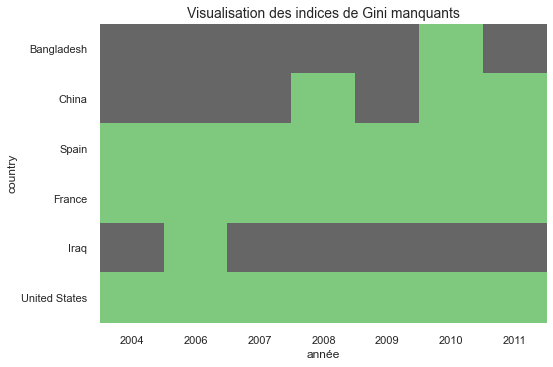

In [125]:
df_pays_choisis_gini_index = df_pays_choisis_gini.drop('country_code', axis=1).set_index('country')
sns.heatmap(df_pays_choisis_gini_index.isnull(),yticklabels=True, cbar=False,cmap='Accent')
plt.title("Visualisation des indices de Gini manquants", size=14)
plt.xlabel('année', size=12)
plt.savefig("nan_gini_pays_initiaux.jpg")

#### Remarque  : de nombreux indice de gini manquent

In [126]:
df_pays_choisis_gini_index

,2004,2006,2007,2008,2009,2010,2011
country,,,,,,,
Bangladesh,NaN,NaN,NaN,NaN,NaN,32.1,NaN
China,NaN,NaN,NaN,43.0,NaN,43.7,42.4
Spain,33.3,33.5,34.1,34.2,34.9,35.2,35.7
France,30.6,29.7,32.4,33.0,32.7,33.7,33.3
Iraq,NaN,28.6,NaN,NaN,NaN,NaN,NaN
United States,40.3,41.4,40.8,40.8,40.6,40.0,40.9


In [127]:
df_gini[df_gini['country_code']== 'TWN']

,country,country_code,2004,2006,2007,2008,2009,2010,2011


In [128]:
# pays avec les gini renseignés de 2004 à 2011 dans le dataframe "df_gini" 
index_with_nan = df_gini.index[df_gini.isnull().any(axis=1)]
df_gini_sans_nan = df_gini.drop(index_with_nan,0)
df_gini_sans_nan.head(2)

,country,country_code,2004,2006,2007,2008,2009,2010,2011
9,Argentina,ARG,48.4,46.3,46.2,44.9,43.7,43.6,42.6
10,Armenia,ARM,37.5,29.7,31.2,29.2,28.0,30.0,29.4


In [129]:
df_gini_sans_nan.shape

(48, 9)

In [130]:
df_gini_sans_nan.columns

Index(['country', 'country_code', '2004', '2006', '2007', '2008', '2009',
       '2010', '2011'],
      dtype='object')

In [131]:
df_gini_sans_nan.head(1)

,country,country_code,2004,2006,2007,2008,2009,2010,2011
9,Argentina,ARG,48.4,46.3,46.2,44.9,43.7,43.6,42.6


In [132]:
df_pays_choisis_gini.head()

,country,country_code,2004,2006,2007,2008,2009,2010,2011
20,Bangladesh,BGD,NaN,NaN,NaN,NaN,NaN,32.1,NaN
40,China,CHN,NaN,NaN,NaN,43.0,NaN,43.7,42.4
70,Spain,ESP,33.3,33.5,34.1,34.2,34.9,35.2,35.7
77,France,FRA,30.6,29.7,32.4,33.0,32.7,33.7,33.3
113,Iraq,IRQ,NaN,28.6,NaN,NaN,NaN,NaN,NaN


In [133]:
df_pays_choisis_gini = df_pays_choisis_gini.copy()

In [134]:
df_pays_choisis_gini.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 20 to 251
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       6 non-null      object 
 1   country_code  6 non-null      object 
 2   2004          3 non-null      float64
 3   2006          4 non-null      float64
 4   2007          3 non-null      float64
 5   2008          4 non-null      float64
 6   2009          3 non-null      float64
 7   2010          5 non-null      float64
 8   2011          4 non-null      float64
dtypes: float64(7), object(2)
memory usage: 480.0+ bytes


In [135]:
df_re_Kmeans_clt.head(2)

,country,nb_habitants_2008,income,gdpppp,cluster
0,Albania,2947314.0,2493.8370,7297.0,0
1,Argentina,40080159.0,4132.6655,13220.0,0


#### Remarque : compte tenu du nombre d'indices de gini manquants pour les pays choisis, je décide de prendre d'autres pays pour lesquels l'indice de gini est renseigné et qui appartiennent au même cluster (bonne qualité de représentation (acp)).
<a class="anchor" id="nvx_pays"></a>

Fusion avec le dataset cluster pour avoir les clusters

In [136]:
df_gini_sans_nan.head(1)

,country,country_code,2004,2006,2007,2008,2009,2010,2011
9,Argentina,ARG,48.4,46.3,46.2,44.9,43.7,43.6,42.6


In [137]:
# Fusion pour récupérer le numéro de cluster
df_gini_cluster = pd.merge(df_re_Kmeans_clt, df_gini_sans_nan, on= 'country', how='right')
df_gini_cluster.head(2)

,country,nb_habitants_2008,income,gdpppp,cluster,country_code,2004,2006,2007,2008,2009,2010,2011
0,Argentina,40080159.0,4132.6655,13220.0,0,ARG,48.4,46.3,46.2,44.9,43.7,43.6,42.6
1,Armenia,2907615.0,1428.1554,5611.0,0,ARM,37.5,29.7,31.2,29.2,28.0,30.0,29.4


- Iraq gpe0 => Turkey
- Spain gpe1 
- Bangladesh gpe2 => Russian Federation
- USA gpe3
- China gpe4 (ou Inde non car 3 manquants)
- France

Liste des pays avec le numéro de cluster

In [138]:
df_gini_cluster.set_index('cluster').sort_values('country')

,country,nb_habitants_2008,income,gdpppp,country_code,2004,2006,2007,2008,2009,2010,2011
cluster,,,,,,,,,,,,
0,Argentina,40080159.0,4132.6655,13220.0,ARG,48.4,46.3,46.2,44.9,43.7,43.6,42.6
0,Armenia,2907615.0,1428.1554,5611.0,ARM,37.5,29.7,31.2,29.2,28.0,30.0,29.4
1,Austria,8321496.0,14569.9170,36193.0,AUT,29.8,29.6,30.6,30.4,31.5,30.3,30.8
0,Belarus,9527985.0,3493.3580,11651.0,BLR,26.5,28.3,29.6,27.8,27.7,28.6,27.2
1,Belgium,10709973.0,13094.9410,33561.0,BEL,30.5,28.1,29.2,28.4,28.6,28.4,28.1
0,Costa Rica,4463123.0,3415.5088,10374.0,CRI,48.3,49.4,49.3,48.6,50.6,48.2,48.7
1,Cyprus,1081568.0,15087.0670,26273.0,CYP,30.1,31.1,31.1,31.7,32.1,31.5,32.6
1,Czech Republic,10384603.0,7298.8510,23223.0,CZE,27.5,26.7,26.0,26.3,26.2,26.6,26.4
1,Denmark,5493621.0,14904.4040,34130.0,DNK,24.9,25.9,26.2,25.2,26.7,27.2,27.3


In [139]:
# df_gini[df_gini['country_code']=='POL']

In [140]:
# df_gini[df_gini['country']=='Morocco']

In [141]:
# Sélection des pays retenus pour la démonstration
gini_index = df_gini.set_index('country')
gini_index = gini_index.loc(axis=0)[pays_choisis]

In [142]:
gini_index

,country_code,2004,2006,2007,2008,2009,2010,2011
country,,,,,,,,
Bangladesh,BGD,NaN,NaN,NaN,NaN,NaN,32.1,NaN
China,CHN,NaN,NaN,NaN,43.0,NaN,43.7,42.4
France,FRA,30.6,29.7,32.4,33.0,32.7,33.7,33.3
Iraq,IRQ,NaN,28.6,NaN,NaN,NaN,NaN,NaN
Spain,ESP,33.3,33.5,34.1,34.2,34.9,35.2,35.7
United States,USA,40.3,41.4,40.8,40.8,40.6,40.0,40.9


In [143]:
df_pays_choisis.head(2)

,country_code,nb_habitants_2008,year,quantile,nb_quantiles,income,gdpppp,country
700,BGD,144304164.0,2010,1,100,276.93503,1233.0,Bangladesh
701,BGD,144304164.0,2010,2,100,332.78653,1233.0,Bangladesh


In [144]:
ll = df_pays_choisis.loc[df_pays_choisis['country'] == 'China', 'income']
ll

1700       16.719418
1701      234.150730
1702      282.894900
1703      323.826500
1704      362.260600
            ...     
1795     7588.195000
1796     8317.553000
1797     9382.284000
1798    11071.510000
1799    17091.404000
Name: income, Length: 100, dtype: float64

In [145]:
indiceGini(ll)

0.4933322469825081

#### Compte tenu du nombre d'indice de Gini manquants pour les pays choisis et désirant conserver les valeurs Gini calculées par la Banque Mondiale, on fait une nouvelle sélection de pays (en fonction de leur appartenance au cluster et de la qualité de leur représentation (acp) ainsi qu'au nombre de gini renseignés) 

Exception :  la Chine car outlier avec l'Inde , les 2 ayant des Gini manquants...
<a class="anchor" id="nvx_pays"></a>

#### Les nouveaux pays choisis sont :  <a class="anchor" id="nvx_pays_liste"></a>

In [146]:
nx_pays_choisis_gini = ['China', 'France', 'Russian Federation', 'Spain', 'Turkey', 'United States']

In [147]:
# récupération des données concernant les pays choisis
df_nx_pays_choisis_gini = df_gini[df_gini['country'].isin(nx_pays_choisis_gini)]
df_nx_pays_choisis_gini.shape

(6, 9)

In [148]:
df_nx_pays_choisis_gini.head(6)

,country,country_code,2004,2006,2007,2008,2009,2010,2011
40,China,CHN,NaN,NaN,NaN,43.0,NaN,43.7,42.4
70,Spain,ESP,33.3,33.5,34.1,34.2,34.9,35.2,35.7
77,France,FRA,30.6,29.7,32.4,33.0,32.7,33.7,33.3
202,Russian Federation,RUS,40.3,41.0,42.3,41.6,39.8,39.5,39.7
244,Turkey,TUR,41.3,39.6,38.4,39.0,39.0,38.8,40.0
251,United States,USA,40.3,41.4,40.8,40.8,40.6,40.0,40.9


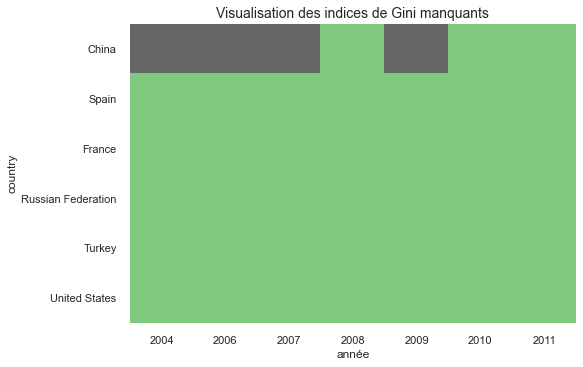

In [149]:
df_nx_pays_choisis_gini_index = df_nx_pays_choisis_gini.drop('country_code', axis=1).set_index('country')
sns.heatmap(df_nx_pays_choisis_gini_index.isnull(),yticklabels=True, cbar=False, cmap='Accent')
plt.title("Visualisation des indices de Gini manquants", size=14)
plt.xlabel('année', size=12)
plt.savefig("Nx_nan_gini_pays.jpg")

https://fr.statista.com/statistiques/666340/indice-de-gini-inegalites-dans-la-distribution-du-revenu-en-chine/

In [150]:
df_nx_pays_choisis = df_revenus_pop[df_revenus_pop['country'].isin(nx_pays_choisis_gini)]
df_nx_pays_choisis.shape

(600, 8)

### Visualisation de la diversité des nouveaux pays choisis en termes de distribution de revenus 
<a class="anchor" id="re_gph_diver_pays"></a>

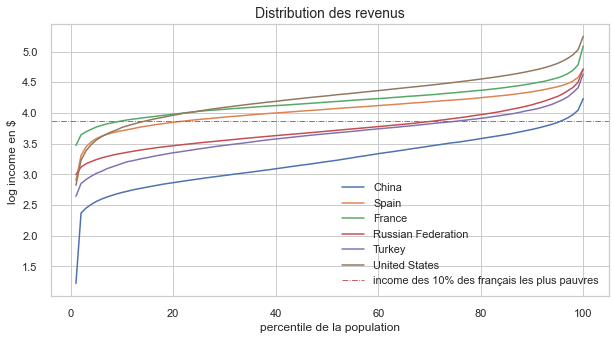

In [151]:
plt.figure(figsize=(10,5))
# sns.set_theme(style="white")
sns.set_theme(style="whitegrid")
sns.lineplot(x="quantile", y= np.log10(df_nx_pays_choisis['income']),
             hue="country", data=df_nx_pays_choisis)
plt.axhline(y = np.log10(7419.52300), color ="r", linestyle ="-.",linewidth=0.9, 
            label='income des 10% des français les plus pauvres')
# plt.axhline(0, label ='Line3', color ='black') 
# plt.hlines(y, xmin, xmax, colors=None, linestyles='solid', label='', *, data=None, **kwargs)
plt.title('Distribution des revenus', size=14)
plt.xlabel('percentile de la population', size=12)
plt.ylabel('log income en $ ')
plt.legend() 
plt.savefig("Distribution des revenus nx_pays.jpg")
# plt.show()

### Courbes de Lorentz pour les nouveaux pays choisis <a class="anchor" id="re_lorentz_pays"></a>

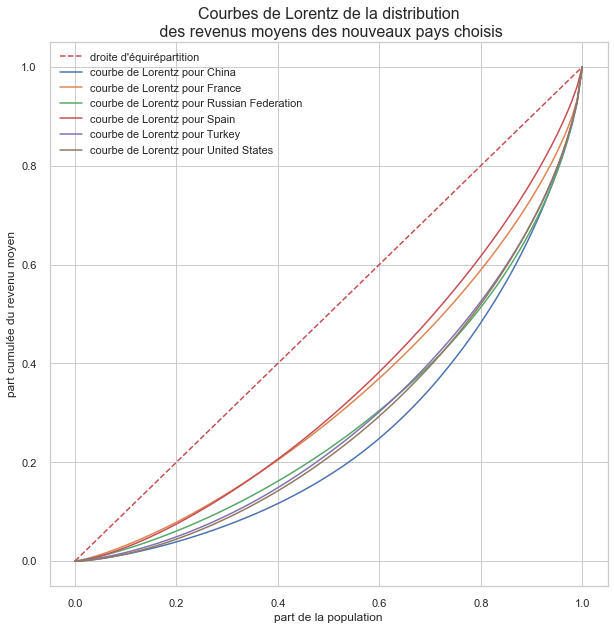

In [152]:
multi_courbeLorentz(df_nx_pays_choisis, nx_pays_choisis_gini, 'part de la population', 'part cumulée du revenu moyen', 'Courbes de Lorentz de la distribution\n des revenus moyens des nouveaux pays choisis')


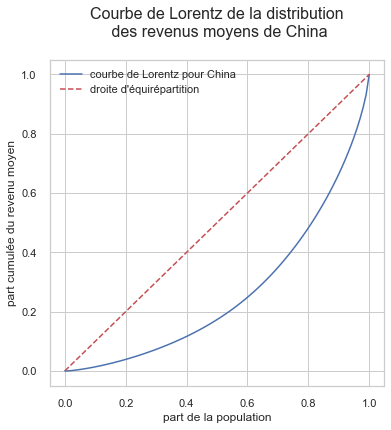

indice de Gini(%) de China : 49.33322469825081


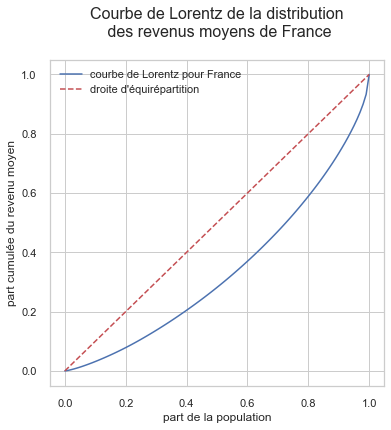

indice de Gini(%) de France : 34.5639840356789


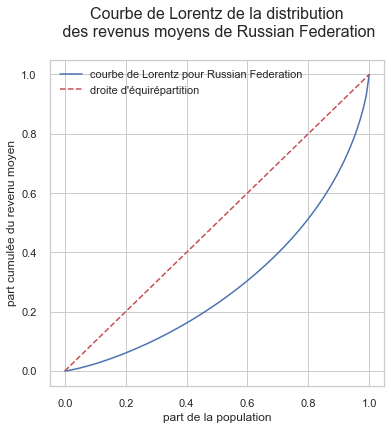

indice de Gini(%) de Russian Federation : 43.23672825933564


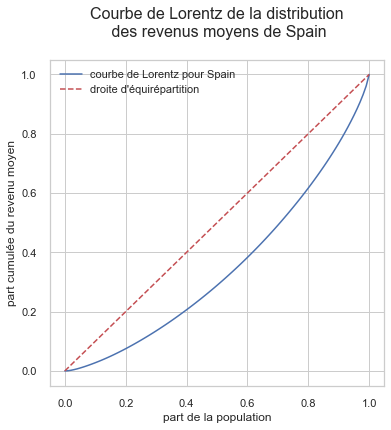

indice de Gini(%) de Spain : 32.41771745833042


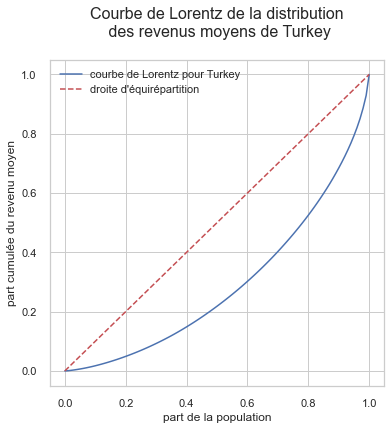

indice de Gini(%) de Turkey : 43.76710757527953


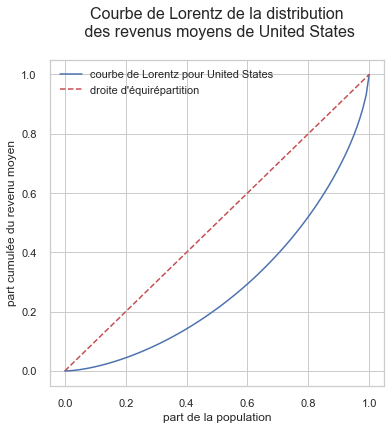

indice de Gini(%) de United States : 44.73259041392895


In [153]:
for pays in nx_pays_choisis_gini :
    nx_lo = df_nx_pays_choisis.loc[df_nx_pays_choisis['country'] == pays, 'income']    
    courbeLorentz(nx_lo, 'part de la population', 'part cumulée du revenu moyen', 
                   f'courbe de Lorentz pour {pays}', f'Courbe de Lorentz de la distribution\n des revenus moyens de {pays}\n')
    print('indice de Gini(%) de {} : {}'.format(pays, indiceGini(nx_lo)*100))
plt.show()

### Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans 
<a class="anchor" id="re_gini_pays"></a>

In [154]:
# récupération des données concernant les pays choisis
df_nx_pays_choisis_gini = df_gini[df_gini['country'].isin(nx_pays_choisis_gini)]
df_nx_pays_choisis_gini.shape

(6, 9)

In [155]:
df_nx_pays_choisis_gini.head(2)

,country,country_code,2004,2006,2007,2008,2009,2010,2011
40,China,CHN,NaN,NaN,NaN,43.0,NaN,43.7,42.4
70,Spain,ESP,33.3,33.5,34.1,34.2,34.9,35.2,35.7


In [156]:
df_nx_pays_choisis = df_revenus_pop[df_revenus_pop['country'].isin(nx_pays_choisis_gini)]
df_nx_pays_choisis.shape

(600, 8)

In [157]:
df_nx_pays_choisis.head(1)

,country_code,nb_habitants_2008,year,quantile,nb_quantiles,income,gdpppp,country
1700,CHN,1.324655e+09,2007,1,100,16.719418,5712.0,China


#### Calcul de l'indice de Gini de 2007 pour la Chine

In [158]:
income_china = df_nx_pays_choisis.loc[df_nx_pays_choisis['country'] == 'China', 'income']

In [159]:
print('L\'indice de Gini de la Chine en 2007 est : {}'.format(indiceGini(income_china)*100))

L'indice de Gini de la Chine en 2007 est : 49.33322469825081


Intégration de l'indice de Gini de la Chine pour 2007 dans le dataset "df_nx_pays_choisis_gini"

In [160]:
df_nx_pays_choisis_gini.head(1)

,country,country_code,2004,2006,2007,2008,2009,2010,2011
40,China,CHN,NaN,NaN,NaN,43.0,NaN,43.7,42.4


In [161]:
df_nx_pays_choisis_gini = df_nx_pays_choisis_gini.copy()

Les indices de Gini des autres années sont récupérés sur le net.  
Indice de Gini : https://www.ceicdata.com/en/china/resident-income-distribution/gini-coefficient

In [162]:
# Introduction des valeurs de l'indice de Gini pour la Chine 
df_nx_pays_choisis_gini.loc[df_nx_pays_choisis_gini['country'] == 'China', '2004']= 47.3
df_nx_pays_choisis_gini.loc[df_nx_pays_choisis_gini['country'] == 'China', '2006']= 48.7
df_nx_pays_choisis_gini.loc[df_nx_pays_choisis_gini['country'] == 'China', '2007']= 49.3
df_nx_pays_choisis_gini.loc[df_nx_pays_choisis_gini['country'] == 'China', '2009']= 49

In [163]:
df_nx_pays_choisis_gini.head(7)

,country,country_code,2004,2006,2007,2008,2009,2010,2011
40,China,CHN,47.3,48.7,49.3,43.0,49.0,43.7,42.4
70,Spain,ESP,33.3,33.5,34.1,34.2,34.9,35.2,35.7
77,France,FRA,30.6,29.7,32.4,33.0,32.7,33.7,33.3
202,Russian Federation,RUS,40.3,41.0,42.3,41.6,39.8,39.5,39.7
244,Turkey,TUR,41.3,39.6,38.4,39.0,39.0,38.8,40.0
251,United States,USA,40.3,41.4,40.8,40.8,40.6,40.0,40.9


In [164]:
df_nx_pays_choisis_giniI = df_nx_pays_choisis_gini.set_index(['country_code']).drop('country', axis=1)
# , 'country_code'

In [165]:
# df_nx_pays_choisis[df_nx_pays_choisis['country']== 'Russian Federation']

In [166]:
df_nx_pays_choisis_giniI.head(6)

,2004,2006,2007,2008,2009,2010,2011
country_code,,,,,,,
CHN,47.3,48.7,49.3,43.0,49.0,43.7,42.4
ESP,33.3,33.5,34.1,34.2,34.9,35.2,35.7
FRA,30.6,29.7,32.4,33.0,32.7,33.7,33.3
RUS,40.3,41.0,42.3,41.6,39.8,39.5,39.7
TUR,41.3,39.6,38.4,39.0,39.0,38.8,40.0
USA,40.3,41.4,40.8,40.8,40.6,40.0,40.9


In [167]:
# income_spain = df_nx_pays_choisis.loc[df_nx_pays_choisis['country'] == 'Russian Federation', 'income']
# indiceGini(income_spain)*100

### Visualisation pour chacun de ces pays, de l'évolution de l'indice de Gini au fil des ans
<a class="anchor" id="evol_gini_pays"></a>

In [168]:
df_nx_pays_choisis_giniI_T = df_nx_pays_choisis_giniI.transpose()

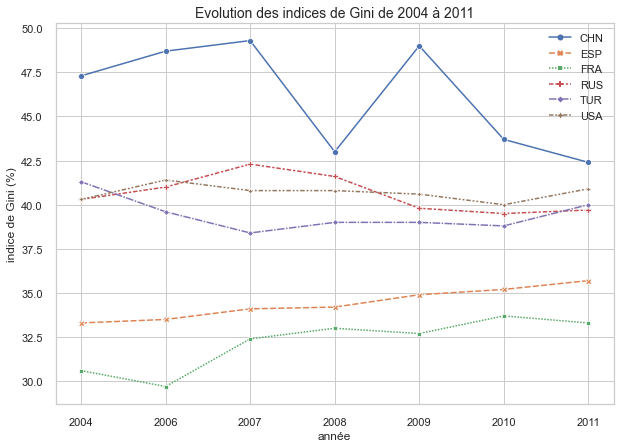

In [169]:
plt.figure(figsize=(10,7))
sns.lineplot(data=df_nx_pays_choisis_giniI_T, markers=True)
plt.title('Evolution des indices de Gini de 2004 à 2011', size=14)
plt.xlabel('année', size=12)
plt.ylabel('indice de Gini (%)', size=12)
plt.legend()
plt.savefig('evolution_indice_gini.jpg')
# plt.show()

### Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?
<a class="anchor" id="class_gini_pays"></a>

In [170]:
df_gini.head(2)

,country,country_code,2004,2006,2007,2008,2009,2010,2011
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
df_gini.shape

(266, 9)

In [172]:
df_distrib_revenus.head(2)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country
0,ALB,2008,1,100,728.89795,7297.0,Albania
1,ALB,2008,2,100,916.66235,7297.0,Albania


In [173]:
# df_distrib_revenus[df_distrib_revenus['country']=='Lithuania']

In [174]:
df_gini.shape

(266, 9)

In [175]:
df_distrib_revenus.shape

(11600, 7)

In [176]:
df_distrib_revenus = df_distrib_revenus.copy()

In [177]:
df_distrib_revenus_code = df_distrib_revenus.drop("country", axis=1)
df_distrib_revenus_code.shape

(11600, 6)

In [178]:
# Fusion pour récupérer le numéro de cluster
df_gini_distrib_revenus = pd.merge(df_distrib_revenus, df_gini, on= 'country_code', how='left')
df_gini_distrib_revenus.head(2)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country_x,country_y,2004,2006,2007,2008,2009,2010,2011
0,ALB,2008,1,100,728.89795,7297.0,Albania,Albania,NaN,NaN,NaN,30.0,NaN,NaN,NaN
1,ALB,2008,2,100,916.66235,7297.0,Albania,Albania,NaN,NaN,NaN,30.0,NaN,NaN,NaN


In [179]:
df_gini_distrib_revenus.shape

(11600, 15)

In [180]:
df_gini_distrib_revenus.isnull().sum()

country_code       0
year               0
quantile           0
nb_quantiles       0
income             0
gdpppp             0
country_x          0
country_y        100
2004            5100
2006            4800
2007            4900
2008            4800
2009            4600
2010            4500
2011            5000
dtype: int64

In [181]:
df_pays_etudies =  df_distrib_revenus.groupby('country_code').mean()
df_pays_etudies_code = df_pays_etudies.reset_index()

In [182]:
df_pays_etudies_code = df_pays_etudies_code[['country_code']]

In [183]:
# Fusion pour récupérer les pays et les indices de Gini correspondants
df_gini_pays = pd.merge(df_pays_etudies_code, df_gini, on= 'country_code', how='left')
df_gini_pays.head(2)

,country_code,country,2004,2006,2007,2008,2009,2010,2011
0,ALB,Albania,NaN,NaN,NaN,30.0,NaN,NaN,NaN
1,ARG,Argentina,48.4,46.3,46.2,44.9,43.7,43.6,42.6


In [184]:
# Liste des pays sans aucun indice de Gini
# Création d'une colonne correspondant à la moyenne des indices de Gini du pays
df_gini_pays['gini_nan']= df_gini_pays.mean(axis=1, skipna=True)
df_gini_pays.loc[df_gini_pays['gini_nan'].isnull(), 'country_code']

37     GHA
55     KEN
57     KHM
71     MNE
95     SRB
100    SYR
105    TWN
114    YEM
Name: country_code, dtype: object

In [185]:
# Calcul des indices de Gini pour ces pays
pays_gini_manquant = ['GHA', 'KEN', 'KHM', 'MNE', 'SRB', 'SYR', 'TWN', 'YEM']
for pays in pays_gini_manquant :
    
    income_country = df_revenus_pop.loc[df_revenus_pop['country_code'] == pays, 'income']
    indice_gini_pm = round(indiceGini(income_country)*100,2)
    print(pays, indice_gini_pm)
    # Introduction des valeurs de l'indice de Gini 
    df_gini_pays.loc[df_gini_pays['country_code'] == pays, '2004']= indice_gini_pm

GHA 44.32
KEN 31.58
KHM 33.04
MNE 30.75
SRB 29.23
SYR 37.39
TWN 33.15
YEM 39.03


In [186]:
# Renseigne le nom de Taïwan pour "country"
df_gini_pays.loc[df_gini_pays['country_code'] == 'TWN', 'country']= 'Taïwan'

In [187]:
# Création d'une colonne correspondant à la moyenne des indices de Gini du pays
df_gini_pays['gini_mean']= round(df_gini_pays.mean(axis=1, skipna=True),1)

In [188]:
df_gini_pays.head(2)

,country_code,country,2004,2006,2007,2008,2009,2010,2011,gini_nan,gini_mean
0,ALB,Albania,NaN,NaN,NaN,30.0,NaN,NaN,NaN,30.0,30.0
1,ARG,Argentina,48.4,46.3,46.2,44.9,43.7,43.6,42.6,45.1,45.1


In [189]:
df_gini_pays[df_gini_pays['country_code']=='TWN']

,country_code,country,2004,2006,2007,2008,2009,2010,2011,gini_nan,gini_mean
105,TWN,Taïwan,33.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.2


In [190]:
df_gini_pays.shape

(116, 11)

In [191]:
df_revenus_pop.head(2)

,country_code,nb_habitants_2008,year,quantile,nb_quantiles,income,gdpppp,country
0,ALB,2947314.0,2008,1,100,728.89795,7297.0,Albania
1,ALB,2947314.0,2008,2,100,916.66235,7297.0,Albania


In [192]:
df_gini_pays.isnull().sum()

country_code     0
country          0
2004            43
2006            48
2007            49
2008            48
2009            46
2010            45
2011            50
gini_nan         8
gini_mean        0
dtype: int64

In [193]:
df_gini_pays.shape

(116, 11)

In [194]:
df_gini_pays[df_gini_pays["country"].isnull()]

,country_code,country,2004,2006,2007,2008,2009,2010,2011,gini_nan,gini_mean


### Les 5 pays avec l'indice de Gini le plus élevé <a class="anchor" id="gini_fort"></a>

In [195]:
df_gini_fort = df_gini_pays.sort_values('gini_mean', ascending=False, ignore_index=True)
df_gini_fort.insert(0, 'Top_gini_eleve', df_gini_fort.index + 1)
df_gini_fort.head(5)

,Top_gini_eleve,country_code,country,2004,2006,2007,2008,2009,2010,2011,gini_nan,gini_mean
0,1,ZAF,South Africa,NaN,NaN,NaN,63.0,NaN,63.4,NaN,63.200000,63.2
1,2,CAF,Central African Republic,NaN,NaN,NaN,56.2,NaN,NaN,NaN,56.200000,56.2
2,3,HND,Honduras,58.1,57.5,55.8,55.5,51.3,53.1,52.6,54.842857,54.8
3,4,GTM,Guatemala,NaN,54.6,NaN,NaN,NaN,NaN,NaN,54.600000,54.6
4,5,BRA,Brazil,56.5,55.6,54.9,54.0,53.7,NaN,52.9,54.600000,54.6


### Les 5 pays avec l'indice de Gini le plus faible <a class="anchor" id="gini_faible"></a>

In [196]:
df_gini_faible = df_gini_pays.sort_values('gini_mean', ascending=True, ignore_index=True)
df_gini_faible.insert(0, 'Top_gini_faible', df_gini_faible.index + 1)
df_gini_faible.head(5)

,Top_gini_faible,country_code,country,2004,2006,2007,2008,2009,2010,2011,gini_nan,gini_mean
0,1,SVN,Slovenia,24.8,24.4,24.4,23.7,24.8,24.9,24.9,24.557143,24.6
1,2,DNK,Denmark,24.9,25.9,26.2,25.2,26.7,27.2,27.3,26.200000,26.2
2,3,SVK,Slovak Republic,27.1,25.8,24.7,26.0,27.2,27.3,26.5,26.371429,26.4
3,4,CZE,Czech Republic,27.5,26.7,26.0,26.3,26.2,26.6,26.4,26.528571,26.5
4,5,AZE,Azerbaijan,26.6,NaN,NaN,NaN,NaN,NaN,NaN,26.600000,26.6


### Position de la France <a class="anchor" id="pos_gini_france"></a>

In [197]:
df_gini_faible[df_gini_faible['country']== 'France']

,Top_gini_faible,country_code,country,2004,2006,2007,2008,2009,2010,2011,gini_nan,gini_mean
33,34,FRA,France,30.6,29.7,32.4,33.0,32.7,33.7,33.3,32.2,32.2


#### La France est en 31ème position pour les indices de Gini croissants sur 166 pays. C'est donc un pays plutôt égalitaire.

In [198]:
# Dataframe avec les indices Gini, les moyennes des indices de gini et les revenus
df_distrib_revenus_gini_annee = pd.merge(df_distrib_revenus_code, df_gini_pays, on= 'country_code', how='left')

In [199]:
df_distrib_revenus_gini_annee.head(2)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country,2004,2006,2007,2008,2009,2010,2011,gini_nan,gini_mean
0,ALB,2008,1,100,728.89795,7297.0,Albania,NaN,NaN,NaN,30.0,NaN,NaN,NaN,30.0,30.0
1,ALB,2008,2,100,916.66235,7297.0,Albania,NaN,NaN,NaN,30.0,NaN,NaN,NaN,30.0,30.0


In [200]:
# Dataframe avec les moyennes des indices de gini et les revenus
annee = ['2004', '2006', '2007', '2008', '2009', '2010', '2011', 'gini_nan']
df_distrib_revenus_mean_gini = df_distrib_revenus_gini_annee.drop(annee, axis=1)
df_distrib_revenus_mean_gini.shape

(11600, 8)

In [201]:
df_distrib_revenus_mean_gini.head(2)

,country_code,year,quantile,nb_quantiles,income,gdpppp,country,gini_mean
0,ALB,2008,1,100,728.89795,7297.0,Albania,30.0
1,ALB,2008,2,100,916.66235,7297.0,Albania,30.0


In [202]:
df_distrib_revenus_mean_gini.isnull().sum()

country_code    0
year            0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
country         0
gini_mean       0
dtype: int64

### Export des dataframes

#### Au format CSV

In [203]:
# Export du dataframe 'revenu_pays_mean_gini' en csv
df_distrib_revenus_mean_gini.to_csv("revenu_pays_mean_gini.csv", index = False, encoding='UTF-8')

#### En utilisant pickle

In [204]:
#  Enregistrement
with open('revenu_pays_mean_gini', 'wb') as f1:
    pickle.dump(df_distrib_revenus_mean_gini, f1)

In [205]:
# Lecture
with open('revenu_pays_mean_gini', 'rb') as f1:
    df_distrib_revenus_mean_gini = pickle.load(f1)